# Linear models

## Generate data

We are given a set of coefficients. We want to try different methods to find a set of coefficients for the linear model that approximates the given ones. 

We are going to generate $m$ examples, each of them consists of $n$ features. Values of the features are between $0$ and $1$. 

In our examples, $n = 3$ and the given coefficients are $\{ 1, 2, 3\}$. Each label (a target value a.k.a $y$) has a form of $1  x_0 + 2 x_1 + 3 x_2 + \texttt{noise}$. We add noise to make the task a bit harder for the model.

In [14]:
import random
import numpy as np

 
"""
Generates training dataset
- `A` is an array of given coefficients
- `m` is the number of exmaples to generate
- `noise` is the scale of noise that will be added to the target variable 
to make the data more realistic.
"""
def generate_data(A, m, noise):
    n = len(A)
    X = np.random.normal(0, 1, (m, n))
    y = np.dot(X, A) + np.random.normal(0, noise, m)
    return X, y


X_train, y_train = generate_data([1, 2, 3], 1000, 0.01)
print(X_train.shape, y_train.shape)

(1000, 3) (1000,)


## Solve with Moore-Penrose inverse method

We want to solve the equation $Xa = y$ => $a = X^{-1}y$. If $X$ is not inverse, use $a = (X^TX)^{-1}X^Ty$

In [15]:
def solve_pseudo_inverse(X, y):
    matrix = np.linalg.inv(np.dot(X.T, X))
    return np.dot(np.dot(matrix, X.T), y)

print(solve_pseudo_inverse(X_train, y_train))

[0.99969828 1.99986846 3.00037701]


As you can see, we got coefficients that are really close to the initial coefs `[1, 2, 3]`.

## Solve using `LinearRegression` model

`solve_sklearn` uses `LinearRegression` model to fit the training data and find the coefficients.

In [16]:
import sklearn
from sklearn.linear_model import LinearRegression


def solve_sklearn(X, y):
    model = LinearRegression()
    model.fit(X, y)
    print(model.coef_)


solve_sklearn(X_train, y_train)

[0.99969073 1.99986865 3.00037917]


## Solve using the Stochastic Gradient Descent function

We can use a loss function $L = (y_{pred} - y_{real})^2 = (\sum\limits_0^{n-1}a_ix_i - y_{real})^2$. We are going to use the gradient of the loss function. The gradient is a matrix consisting of derivatives, each of them has a form $\frac{\partial L}{\partial a_i} = L'_{a_i} = 2 (\sum\limits_0^{n-1}a_ix_i - y_{real}) x_i$

In [17]:
def solve_sgd(X, y, iterations, learning_rate):
    n = X.shape[1]
    a = np.zeros(n)
    
    for i in range(iterations):
        t = 2 * (np.dot(X, a) - y) * X.T
        t = np.mean(t, axis = 1)
        a -= t * learning_rate
    return a
    
print (solve_sgd(X_train, y_train, 1000, 0.01))

[0.99969827 1.99986843 3.00037697]


The `solve_sgd` function first initializes vector `a` with zeros and iteratively updates it in order to minimize the loss function error. In each iteration, it computes the gradient `t` for the current vector `a` and updates the coefficients.

`np.mean(t, axis = 1)` finds the average over all examples in the dataset. For example, $t_1$ is the average of derivatives' values for the coefficient $a_1$. 

`learning_rate` is a hyperparameter that determines the step size in the direction of the gradient. Typically, it is a positive number between $0$ and $1$ that scales the gradient before applying it to update coefficients.



## Check for overfitting

In [18]:
import matplotlib.pyplot as plt

def calculate_loss(a, X, y):
    t = np.dot(X, a) - y
    t *= t
    return np.mean(t)

def solve_sgd_and_plot(X_train, y_train, X_test, y_test, iterations, learning_rate):
    n = X_train.shape[1]
    a = np.zeros(n)
    train_losses, test_losses = [], []
    
    for _ in range(iterations):
        t = 2 * (np.dot(X_train, a) - y_train) * X_train.T
        t = np.mean(t, axis = 1)
        a -= t * learning_rate
        train_losses.append(calculate_loss(a, X_train, y_train))
        test_losses.append(calculate_loss(a, X_test, y_test))
        
    plt.plot(train_losses, label = 'train')
    plt.plot(test_losses, label = 'test')
    plt.legend()
    plt.show()
    
    return a

Lets add more noise into the training and test datasets while generating data (`noise = 10.01`). We get coefficients far from the initial ones. As a result, the model overfits: the `test` curve does not go as the `train` curve. 

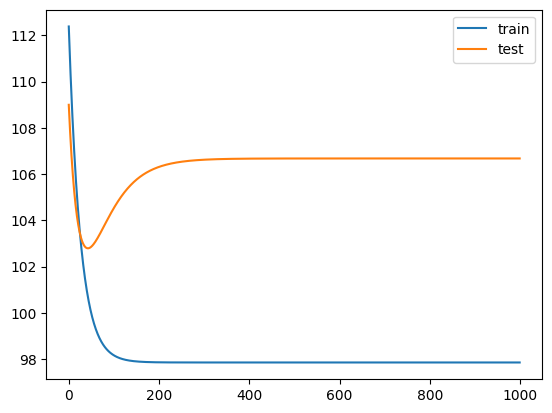

[1.69279344 2.01623527 2.98078911]


In [19]:
X_train, y_train = generate_data([1, 2, 3], 1000, 10.01)
X_test, y_test = generate_data([1, 2, 3], 100, 10.01)
print(solve_sgd_and_plot(X_train, y_train, X_test, y_test, 1000, 0.01))

Now lets remove noise (`noise = 0.01`):

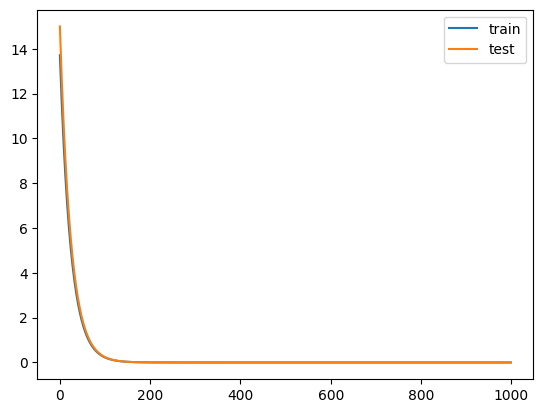

[1.00078675 2.00005644 3.00067106]


In [20]:
X_train, y_train = generate_data([1, 2, 3], 1000, 0.01)
X_test, y_test = generate_data([1, 2, 3], 100, 0.01)
print(solve_sgd_and_plot(X_train, y_train, X_test, y_test, 1000, 0.01))

# Decision trees

## Boosting tree 

In [27]:
import catboost


def solve_catboost(X, y, iterations, learning_rate, depth):
    model = catboost.CatBoostRegressor(iterations = iterations, 
                                       learning_rate = learning_rate, 
                                       depth = depth)
    model.fit(X, y, verbose = False)
    return model
    
    
X_train, y_train = generate_data([1, 2, 3], 1000, 0.01)
X_test, y_test = generate_data([1, 2, 3], 100, 0.01)
model = solve_catboost(X_train, y_train, 1000, 0.1, 6)

A `CatBoostRegressor` model is trained using the `solve_catboost` function:
- `iterations` is the amount of decision trees
- `learning_rate` is used for controlling the step size in the direction of the gradient
- `depth` - depth of decision trees 

It is a bad idea to print all 1000 trees, with each of them having 6 layers. But we can visualize the training and testing performance during the training process. 

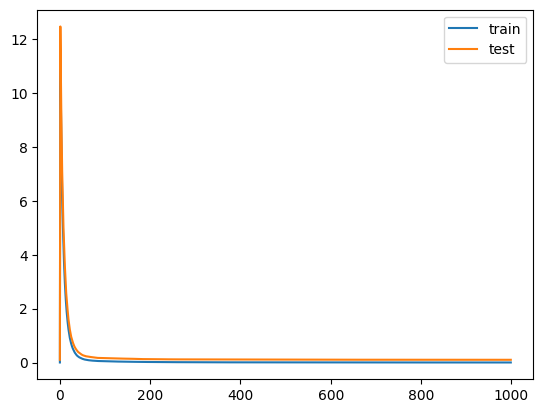

In [28]:
def plot_catboost(X_train, y_train, X_test, y_test, model):
    m = model.tree_count_
    train_losses, test_losses = [], []
    for k in range(m):
        t = model.predict(X_train, ntree_end = k)
        t = (t - y_train) ** 2
        train_losses.append(np.mean(t))
        t = model.predict(X_test, ntree_end = k)
        t = (t - y_test) ** 2
        test_losses.append(np.mean(t))
    plt.plot(train_losses, label = "train")
    plt.plot(test_losses, label = "test")
    plt.legend()
    plt.show()


plot_catboost(X_train, y_train, X_test, y_test, model)

The plot helps visualize how the model's performance evolves over the boosting iterations. The X-axis represents the number of trees, and the Y-axis represents the mean squared error (MSE) values.